**First, import all the modules we need**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
import astropy.units as u
from scipy.integrate import solve_ivp
import scipy.optimize as op

**Next, define the complex equation of state (EOS) functions**

In [6]:
def solarmet():
    """Return solar metalicity abundances by number and masses for low mass elements.
    From Asplund et al (2009), up to Oxygen only"""
    abund = 10**np.array([0.00,-1.07,-10.95,-10.62,-9.3,-3.57,-4.17,-3.31])
    masses=  np.array([1.0, 4.0, 6.94, 9.01, 10.81, 12.01, 14.01, 16.00])
    return abund, masses
    
def simplified_eos_rho_T(rho, T):
    """Assume that H and He are ionised. Return the gas pressure for this density and
    the adiabatic gamma
    
    Parameters
    ----------
    rho: Density, including units from astropy units.
    T: Temperature, including units from astropy units.
    
    Returns
    -------
    Pressure, including units from astropy.units
    Adiabatic index (dimensionless)
    """
    #Input the abundances of the elements
    abund, masses = solarmet()
    
    #Find the number density of H
    n_h = rho/(np.sum(abund*masses)*u.u)
    
    #Assume that H and He are totally ionized. Ignore heavier elements.
    n_e = n_h*(abund[0] + 2*abund[1])
    
    #Now find total pressure.
    P = ((n_h*np.sum(abund) + n_e)*c.k_B*T).cgs
    
    return P, 5/3
    
def saha(n_e, T):
    """Compute the solution to the Saha equation as a function of electron number
    density and temperature. This enables the problem to be a simple Ax=b linear problem.
    Results from this function can be used to solve the Saha equation as e.g. a function 
    of rho and T via e.g. tabulating or solving.
    
    Parameters
    ----------
    n_e: the dimensioned electron number density
    T: Temperature in K.
    
    Returns
    -------
    rho: astropy.units quantity compatible with density
    mu: Mean molecular weight (dimensionless, i.e. to be multiplied by the AMU)
    ns: A vector of number densities of H, H+, He, He+, He++
    
    """
    #Input the abundances of the elements
    abund, masses = solarmet()
    
    #This will break for very low temperatures. In this case, fix a stupidly low 
    #ionization fraction
    if (T<1500*u.K):
        ns = n_e*1e15*np.array([abund[0],0,abund[1],0,0])
    else:
        #The thermal de Broglie wavelength
        debroglie=np.sqrt(c.h**2/2/np.pi/c.m_e/c.k_B/T)
    
        #Hydrogen ionization. We neglect the excited states because
        #they are only important when the series diverges... 
        h1  = 2./debroglie**3 *1/2*np.exp(-13.6*u.eV/c.k_B/T)  
    
        #Helium ionization. NB excited states are still nearly ~20ev higher.
        he1 = 2./debroglie**3 *2/1*np.exp(-24.580*u.eV/c.k_B/T) 
    
        #Helium double-ionization
        he2 = 2./debroglie**3 *1/2*np.exp(-54.403*u.eV/c.k_B/T)
    
        #Now construct our matrix of 5 equations defining these number densities.
        A = np.zeros( (5,5) );
        A[0,0:2]=[-h1/n_e,1]
        A[1,2:4]=[-he1/n_e,1]
        A[2,3:5]=[-he2/n_e, 1]
        A[3,:]  =[abund[1],abund[1],-abund[0],-abund[0],-abund[0]]
        A[4,:] =[0,1,0,1,2]
        #This has dimensions
        b=[0,0,0,0,n_e.to(u.cm**(-3)).value]
        ns =np.linalg.solve(A,b)*u.cm**(-3)
    
    #The next lines ensure ionization at high T, due to nuclei being separated by less. 
    #than the Debye length. Somewhat of a hack, but eventually the Saha equation does 
    #break down...
    ns_highT=[0,abund[0],0,0,abund[1]]
    ns_highT=ns_highT/(abund[0]+2*abund[1])*n_e
    if (T > 2e6*u.K):
        ns=ns_highT
    elif (T > 1e6*u.K):
        frac=(T.to(u.K).value-1e6)/1e6
        ns = frac*ns_highT + (1-frac)*ns
        
    #For normalization... we need the number density of Hydrogen
    #nuclei, which is the sum of the number densities of H and H+.
    n_h = np.sum(ns[:2])
    
    #Density. Masses should be scalars.
    rho = n_h*np.sum(abund*masses)*u.u
    
    #Fractional "abundance" of electrons.
    f_e = n_e/n_h
    
    #mu is mean "molecular" weight, and we make the approximation that
    #electrons have zero weight.
    mu = np.sum(abund*masses)/(np.sum(abund) + f_e)
    
    #Finally, we should compute the internal energy with respect to neutral gas.
    #This is the internal energy per H atom, divided by the mass in grams per H atom. 
    Ui=(ns[1]*13.6 + ns[3]*24.58 + ns[4]*(54.403+24.58))*u.eV/n_h/np.sum(abund*masses*u.u);
    
    return rho, mu, Ui, ns
    
def saha_solve(log_n_e_mol_cm3, T, rho_0_in_g_cm3):
    """Dimensionless version of the Saha equation routine, to use in np.solve to
    solve for n_e at a fixed density."""
    n_e = np.exp(log_n_e_mol_cm3[0])*c.N_A.value/u.cm**3
    rho, mu, Ui, ns = saha(n_e, T)
    
    return rho.to(u.g/u.cm**3).value - rho_0_in_g_cm3
    
def eos_rho_T(rho, T, full_output=False):
    """Compute the key equation of state parameters via the Saha equation
    
    Parameters
    ----------
    rho: rho: astropy.units quantity compatible with density
    T: gas Temperature
    
    Returns
    -------
    P: Gas Pressure
    n_e: Electron number density
    ns: Number densities of H, H+, He, He+, He++
    mu: Mean molecular weight in atomic mass units
    Ui: Internal energy per unit mass due to ionization
    """
    rho_in_g_cm3 = rho.to(u.g/u.cm**3).value
    #Start with the electron number density equal in mol/cm^3 equal to the density
    #in g/cm^3
    x0 = np.log(rho_in_g_cm3)
    res = op.fsolve(saha_solve, x0, args=(T, rho_in_g_cm3), xtol=1e-6)
    
    #Now evaluate the saha equation one more time
    n_e = np.exp(res[0])*c.N_A.value/u.cm**3
    rho_check, mu, Ui, ns = saha(n_e, T)
    
    #The total gas pressure is just the sum of the number densities multiplied by kT
    #!!! We should take heavier elements into account here as well, and wrap this in 
    #a function. Maybe simpler just to add in more elements to Saha?
    P = ((np.sum(ns) + n_e)*c.k_B*T).cgs
    
    #Next, find the adaibatic exponent. As we are neglecting radiation, pressure, there
    #is only a single gamma (e.g. https://ui.adsabs.harvard.edu/abs/2002ApJ...581.1407S/abstract)
    #We will do this two different ways, to double-check. I'm double checking because 
    #the results didn't seem to exactly match Unsold's 1968 book:
    #Physik der Sternatmosphaeren MIT besonderer Beruecksichtigung der Sonne, which is 
    #referenced in e.g.
    #http://www.ifa.hawaii.edu/users/kud/teaching/4.Convection.pdf
    
    #In both cases, we need to numerically compute derivatives. We do this by slightly
    #increasing temperature and density, and re-calculating.
    dlog = 1e-4
    #Increase temperature
    res_Tplus = op.fsolve(saha_solve, res[0], args=(T*np.exp(dlog), rho_in_g_cm3), xtol=1e-6)
    n_e_Tplus = np.exp(res_Tplus[0])*c.N_A.value/u.cm**3
    rho_check, mu_Tplus, Ui_Tplus, ns_Tplus = saha(n_e_Tplus, T*np.exp(dlog))
    P_Tplus = ((np.sum(ns_Tplus) + n_e_Tplus)*c.k_B*T*np.exp(dlog)).cgs
    #Increase Density
    res_rhoplus = op.fsolve(saha_solve, res[0], args=(T, rho_in_g_cm3*np.exp(dlog)), xtol=1e-6)
    n_e_rhoplus = np.exp(res_rhoplus[0])*c.N_A.value/u.cm**3
    rho_check, mu_rhoplus, Ui_rhoplus, ns_rhoplus = saha(n_e_rhoplus, T)
    P_rhoplus = ((np.sum(ns_rhoplus) + n_e_rhoplus)*c.k_B*T).cgs
    #Compute the 4 logarithmic derivatives. We scale internal energy by rho/P to make
    #it dimensionless.
    dUidlrho_scaled = float( (Ui_rhoplus - Ui)/dlog*rho/P )
    dUidlT_scaled = float( (Ui_Tplus - Ui)/dlog*rho/P )
    dlPdlrho = float( (P_rhoplus - P)/dlog/P )
    dlPdlT = float( (P_Tplus - P)/dlog/P )
    
    #Now the tricky bit. We have to use partial derivative relations to move from 
    #Ui(rho, T) to Ui(rho, P), which we call UU.
    dUUdlrho_scaled = dUidlrho_scaled - dUidlT_scaled * (dlPdlrho/dlPdlT)
    dUUdlP_scaled = dUidlT_scaled / dlPdlT

    #The following comes directly from the definition of adiabatic, from e.g. the derivation
    #on page 5 of https://websites.pmc.ucsc.edu/~glatz/astr_112/lectures/notes6.pdf
    gamma = (5/2 - dUUdlrho_scaled) / (3/2 + dUUdlP_scaled)
    
    # For method 2, see equation 18.8 on page 571 of Cox and Guili. 
    #We need an additional two normalised logarithmic derivatives. 
    #They are all zero in the absence of a phase change
    dlmudlT = float( (mu_Tplus - mu)/mu/dlog )
    dlmudlrho = float( (mu_rhoplus - mu)/mu/dlog )
    dUidlT_scaled = float( (Ui_Tplus - Ui)/dlog*mu*u.u/c.k_B/T)
        
    #Composition quantities to match Cox and Guili's equations. As far as I can tell,
    #this gamma is identical to the gamma above, so a great check.
    chi_T    = 1 - dlmudlT
    chi_rho  = 1 - dlmudlrho
    gamma_old = chi_rho + chi_T**2/(3/2*chi_T + dUidlT_scaled)
    
    if full_output:
        return P, n_e, ns, mu, Ui, gamma
    else:
        return P, gamma 

**Now we can define our main function - something that returns the results of the three modified equations of stellar structure for a given r, M, rho and T**

In [7]:
def find_derivatives(r_in_rsun, M_lrho_lT, simplified_EOS=False):
    """Given an interior mass M, a density logarithm rho and a pressure logarithm P, 
    find the derivatives of M and P. Derivatives are in units of solar radii.
    Logarithms are natural logarithms in cgs units.
    
    Parameters
    ----------
    r_in_rsun: radius to compute derivatives in solar units
    M_lrho_lT: numpy array-like, including M in solar units, log(rho in g/cm^3), and
        log(T in K).
        
    Returns
    -------
    derivatives: Derivatives of M in solar units, log(rho in g/cm^3), and
        log(T in K) with respect to r_in_rsun, as a numpy array-like variable.
    """
    M_in_Msun, lrho, lT = M_lrho_lT
    #Mass continuity
    dM_in_Msundr = 4*np.pi*r_in_rsun**2*np.exp(lrho) * float(c.R_sun**3*u.g/u.cm**3/c.M_sun)
    
    #Equation of state.
    if simplified_EOS:
        P, gamma = simplified_eos_rho_T(np.exp(lrho)*u.g/u.cm**3, np.exp(lT)*u.K)
    else:
        P, gamma = eos_rho_T(np.exp(lrho)*u.g/u.cm**3, np.exp(lT)*u.K)
    
    #(logarithmic) density derivative. Firstly, avoid a divide by zero by taking a limit
    #for r=0 and constant rho at the star's center.
    if M_in_Msun == 0:
        dlrhodr = 0
    else:
        #Put all parameters with units on the second line for neatness.
        dlrhodr = -1/gamma * (M_in_Msun)*np.exp(lrho)/P.cgs.value/r_in_rsun**2 *\
         float(c.G*c.M_sun/c.R_sun * (u.g/u.erg) )
    
    #(logarithmic) temperature derivative.
    dlTdr = (gamma - 1) * dlrhodr
    # dlTdr = 
    
    return np.array([dM_in_Msundr, dlrhodr, dlTdr])

**This function is wrapped for convenience, and surface stopping condition functions are defined**

In [8]:
def find_derivatives_simplified(r_in_rsun, M_lrho_lT):
    """A wrapper function to force a simplified equation of state"""
    return find_derivatives(r_in_rsun, M_lrho_lT, simplified_EOS=True)


#The following two functions may be slightly confusing for people who aren't python or 
#object oriented programming experts, as variables (properties) are added to a function. 
#We can actually always add additional properties to functions, ad all variables and
#functions in python are objects.
def cool_surface(r_in_rsun, M_lrho_lT):
    """Determine a surface condition by the surface becoming too cool. In practice, 
    our adiabatic approximation is likely to break before this!"""
    return M_lrho_lT[2] - np.log(2000)
cool_surface.terminal = True
cool_surface.direction = -1

def near_vacuum(r_in_rsun, M_lrho_lT):
    """Determine a surface condition by the surface becoming too cool. In practice, 
    our adiabatic approximation is likely to break before this!"""
    return M_lrho_lT[1] - np.log(1e-7)
near_vacuum.terminal = True
near_vacuum.direction = -1

**Finally, we're up to defining our core function which creates a numerical approximation to a fully convective star**

In [277]:
def convective_star(rho_c, T_c, simplified_EOS=False):
    """Assuming a fully convective star, compute the structure using an equation of
    state and the first two equations of stellar structure.
    
    Parameters
    ----------
    rho_c: Central density, including units from astropy.units
    T_c: Central temperature, including units from astropy.units
    simplified_EOS: True or False - do we use a simplified equation of state
        with a fixed gamma (from a fixed ionisation fraction)?
    """
    #Start the problem at the star center.
    y0 = [0, np.log(rho_c.to(u.g/u.cm**3).value), np.log(T_c.to(u.K).value)] 
    
    #Don't go past 100 R_sun!
    rspan = [0,2] 
    
    #Solve the initial value problem!
    if simplified_EOS:
        result = solve_ivp(find_derivatives_simplified, rspan, y0, events=[cool_surface, near_vacuum], method='RK23',max_step = 0.01)
    else:
        result = solve_ivp(find_derivatives, rspan, y0, events=[cool_surface, near_vacuum], method='RK23',max_step = 0.01)
    
    #Extract the results
    r_in_rsun = result.t
    M_in_Msun = result.y[0]
    rho = np.exp(result.y[1])*u.g/u.cm**3
    T = np.exp(result.y[2])*u.K
    return r_in_rsun, M_in_Msun, rho, T

**From this point, you'll have to run convective_star(), e.g. as** <br>
`r_in_rsun, M_in_Msun, rho, T = convective_star(INSERT_DENSITY_HERE, INSERT_TEMPERATURE_HERE)`<br>
**... then you can try to make pretty plots etc. Enjoy! Note that without the simplified_EOS option, this takes several seconds to run.**

In [278]:
r_in_rsun_sim, M_in_Msun_sim, rho_sim, T_sim = convective_star(1*u.g/u.cm**3, 3e6*u.K, simplified_EOS = True)
r_in_rsun, M_in_Msun, rho, T= convective_star(1*u.g/u.cm**3, 3e6*u.K)    

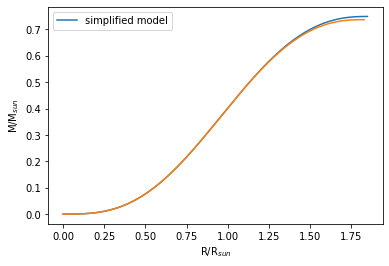

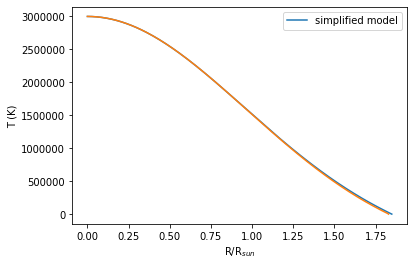

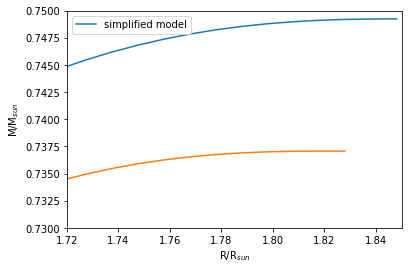

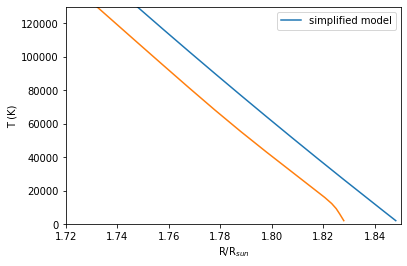

In [279]:
plt.figure(1)
plt.plot(r_in_rsun_sim, M_in_Msun_sim,label = 'simplified model')
plt.plot(r_in_rsun, M_in_Msun)
plt.xlabel('R/R$_{sun}$');plt.ylabel('M/M$_{sun}$');plt.legend()

plt.figure(2)
plt.plot(r_in_rsun_sim, T_sim,label = 'simplified model')
plt.plot(r_in_rsun, T)
plt.xlabel('R/R$_{sun}$');plt.ylabel('T (K)');plt.legend()

plt.figure(3)
plt.plot(r_in_rsun_sim, M_in_Msun_sim,label = 'simplified model')
plt.plot(r_in_rsun, M_in_Msun)
plt.xlabel('R/R$_{sun}$');plt.ylabel('M/M$_{sun}$');plt.legend()
plt.axis([1.72, 1.85, 0.73, 0.75])

plt.figure(4)
plt.plot(r_in_rsun_sim, T_sim,label = 'simplified model')
plt.plot(r_in_rsun, T)
plt.xlabel('R/R$_{sun}$');plt.ylabel('T (K)');plt.legend()
plt.axis([1.72, 1.85, 0,130000])

plt.legend()

They are significant difference near the surface layers
the greatest cause of the difference.

In [280]:
dTdr_rad = 3.75e-17*T**7*rho**1.8/u.K**6/u.g**1.8*u.cm**5.4/u.m

In [284]:
# compute the convective temperature gradient
dTdr = np.zeros(np.size(r_in_rsun))*u.K/u.m
for i in range(np.size(r_in_rsun)):
    P, gamma = eos_rho_T(rho[i], T[i])
    #dlrhodr = -1/gamma * (M_in_Msun_sim)*rho_sim/P.cgs.value/r_in_rsun_sim**2 *\
    #         c.G*c.M_sun/c.R_sun * (u.cm**3/u.erg) 

    #(logarithmic) temperature derivative.
    dTdr[i] = (((gamma - 1)/gamma * T[i]/P *c.G*M_in_Msun[i]*c.M_sun*rho[i]/r_in_rsun[i]**2/c.R_sun**2)).to(u.K/u.m)

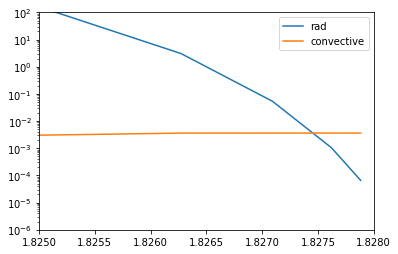

In [304]:
plt.semilogy(r_in_rsun, dTdr_rad,label = 'rad')
plt.semilogy(r_in_rsun, dTdr, label = 'convective')
plt.axis([1.825,1.828,1e-6,1e2])
plt.legend()

In [300]:
# From above plot we know that the transition radius is about 1.827 R_sun
# We calculate the temperature at this radius by interpolation
from scipy import interpolate
from scipy.misc import derivative
f = interpolate.interp1d(r_in_rsun, T/u.K)

f(1.827)

array(4223.74952076)

In [298]:
# We calculate the luminosity of the star.
L = 4*np.pi*c.sigma_sb*1.827**2*c.R_sun**2*(4223*u.K)**4
L.to(u.L_sun)

<Quantity 0.95643295 solLum>